Target voltage 701V is below the minimum. Extrapolating using 880V and 1080V.
Target voltage 691V is below the minimum. Extrapolating using 880V and 1080V.
Target voltage 691V is below the minimum. Extrapolating using 880V and 1080V.
Target voltage 690V is below the minimum. Extrapolating using 880V and 1080V.
Target voltage 692V is below the minimum. Extrapolating using 880V and 1080V.
Target voltage 690V is below the minimum. Extrapolating using 880V and 1080V.
Target voltage 689V is below the minimum. Extrapolating using 880V and 1080V.
Target voltage 684V is below the minimum. Extrapolating using 880V and 1080V.
Target voltage 679V is below the minimum. Extrapolating using 880V and 1080V.
Target voltage 683V is below the minimum. Extrapolating using 880V and 1080V.
Target voltage 687V is below the minimum. Extrapolating using 880V and 1080V.
Target voltage 680V is below the minimum. Extrapolating using 880V and 1080V.
Target voltage 680V is below the minimum. Extrapolating using 88

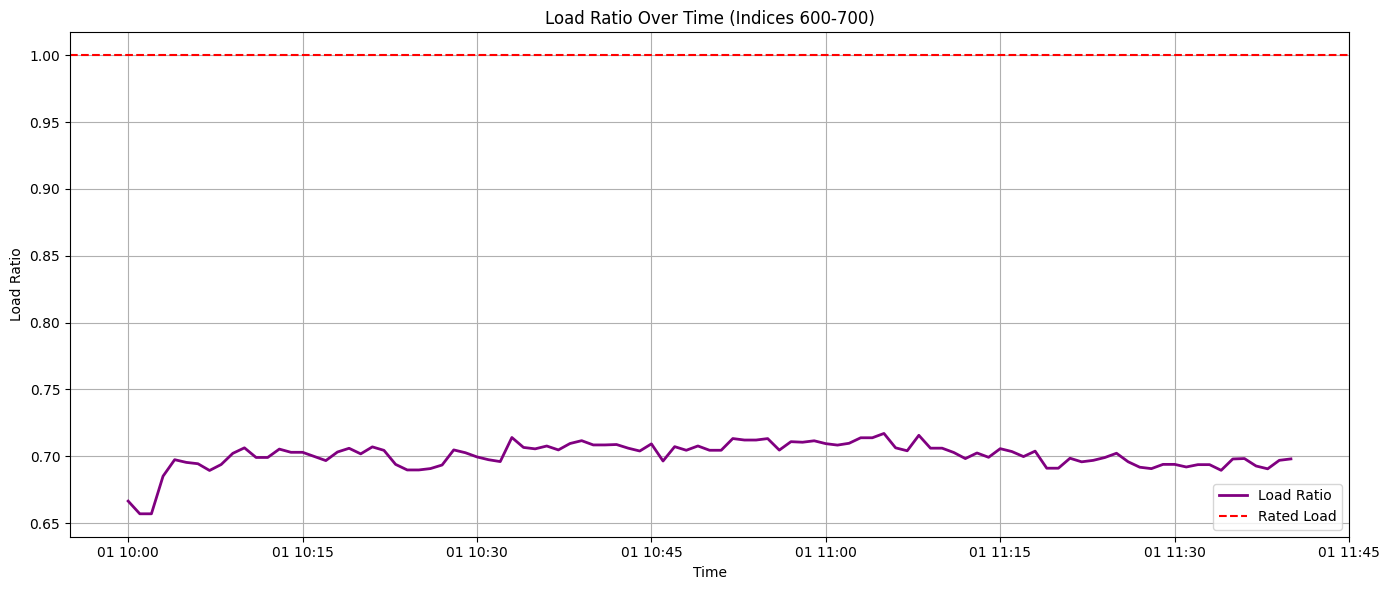

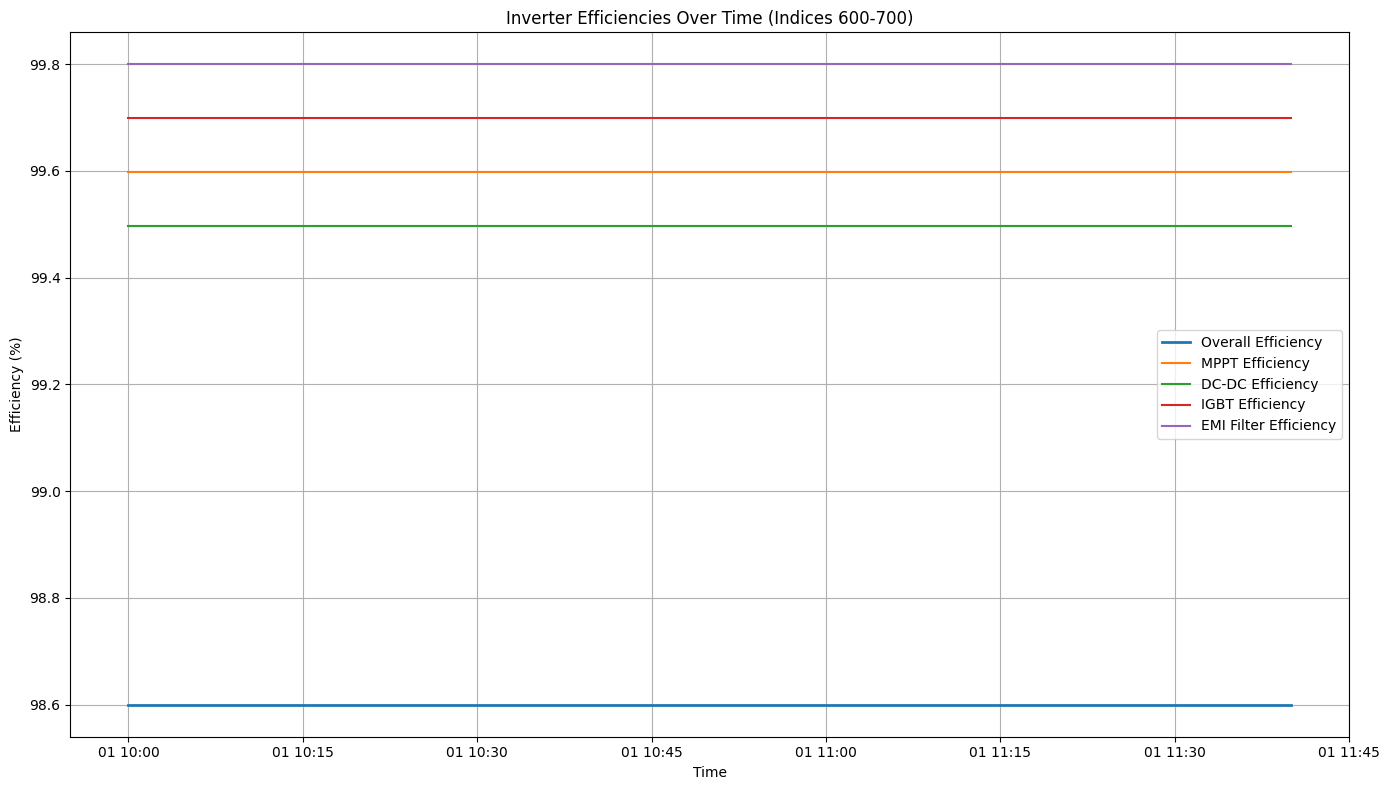

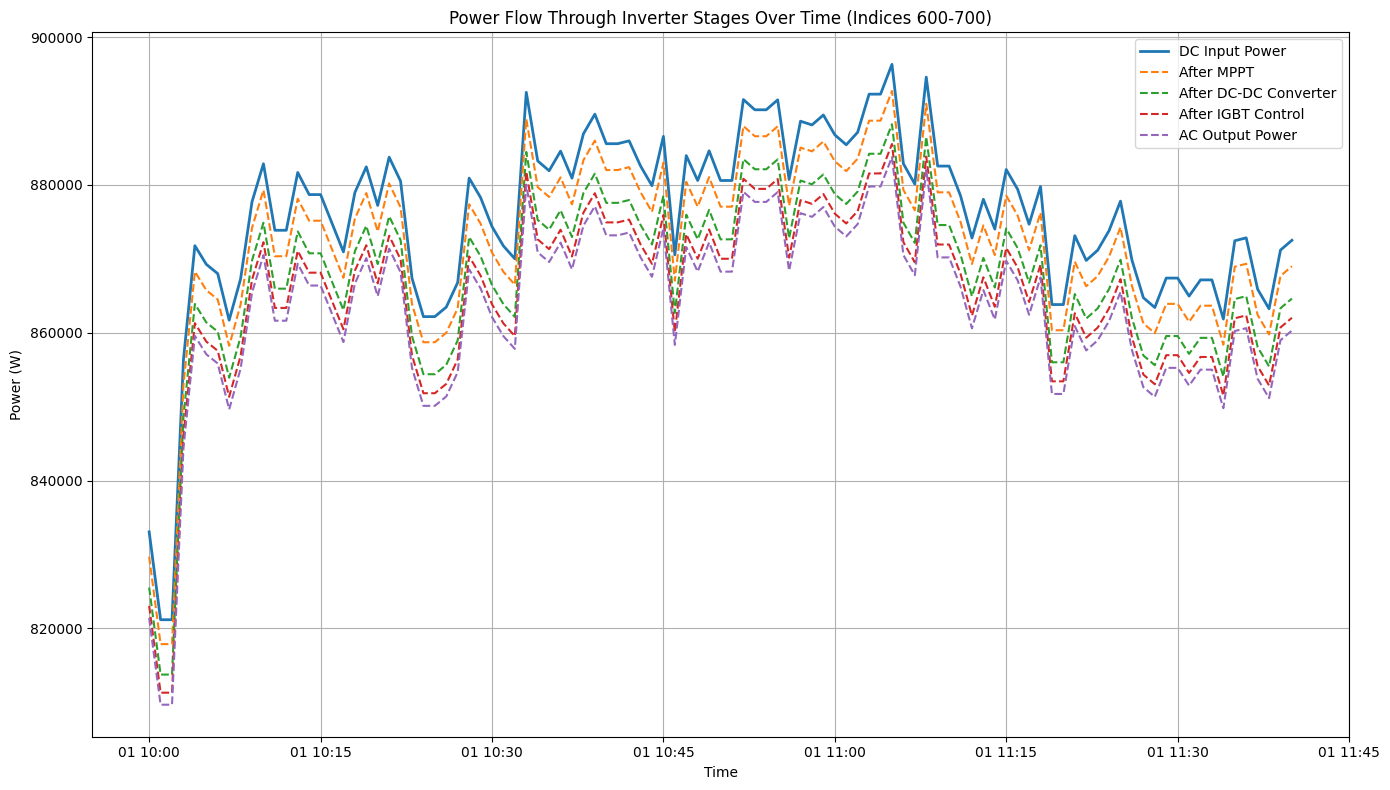

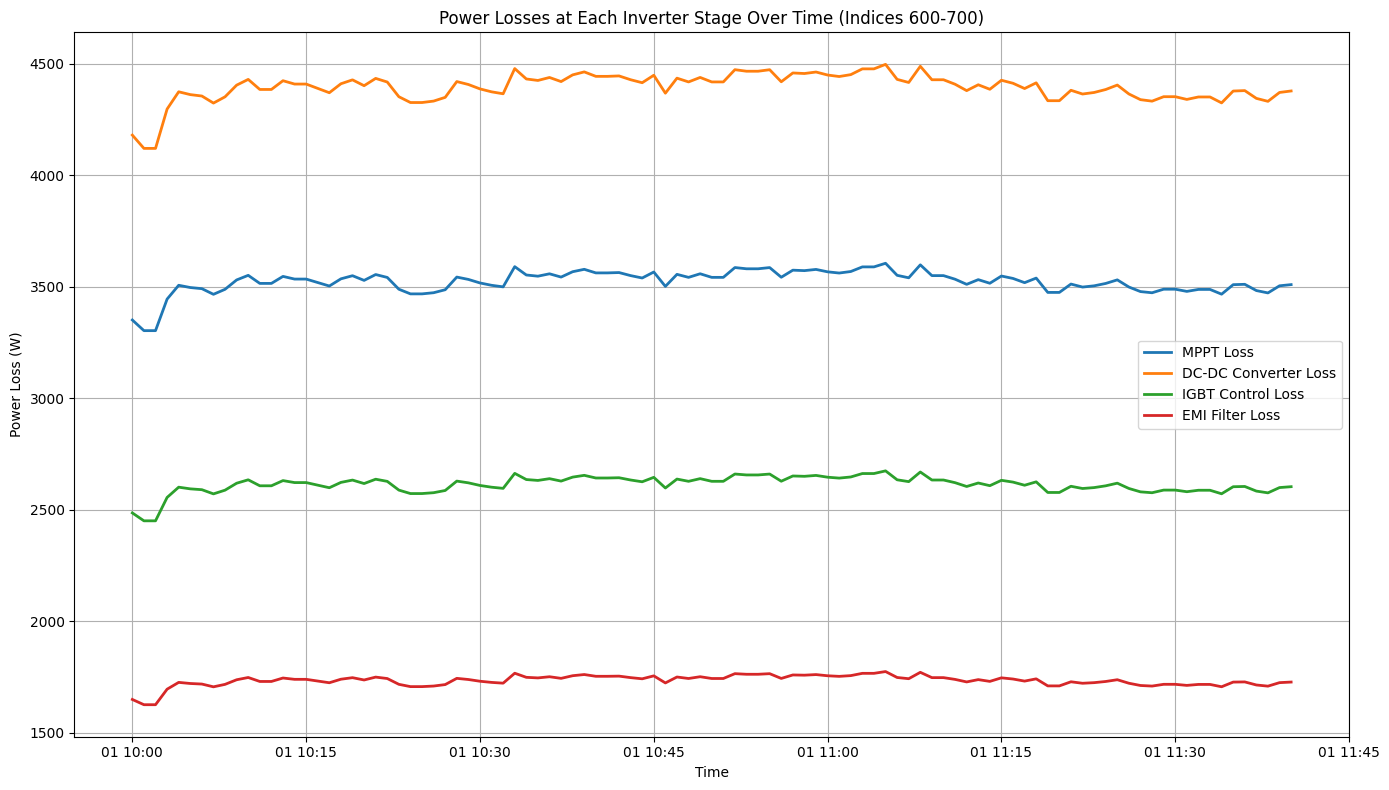

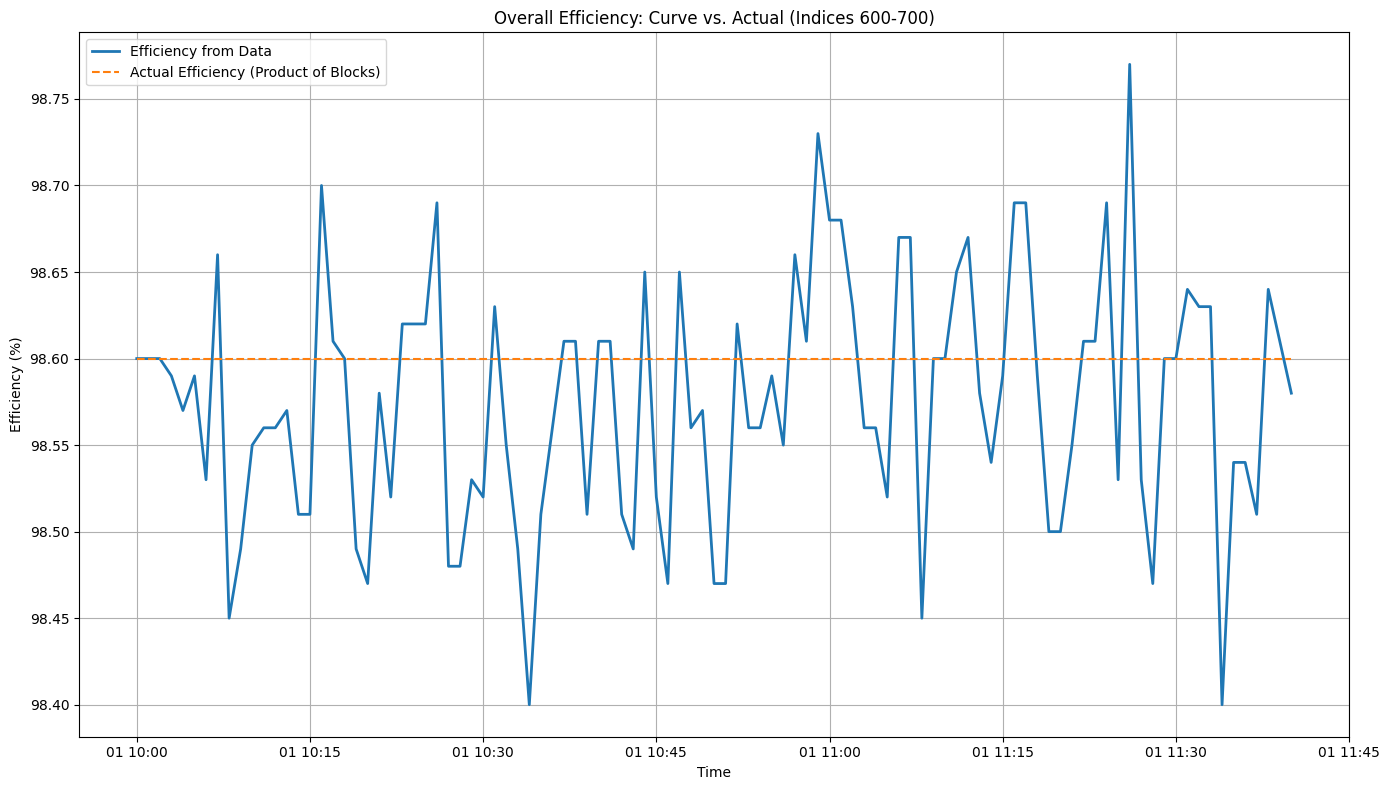


Processed data saved to 'processed_inverter_data_indices_600_700.csv'.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# Inverter Efficiency Modeling
# ===============================

# Efficiency curves for different voltages and load ratios
efficiency_curves = {
    880: [95.9, 97, 97.8, 98.2, 98.3, 98.4, 98.4, 98.4, 98.4, 98.4, 98.3],
    1080: [96.2, 97.3, 98, 98.4, 98.5, 98.6, 98.6, 98.6, 98.6, 98.6, 98.6],
    1190: [96.9, 98, 98.4, 98.8, 98.9, 99, 99, 99, 99, 99, 99],
    1300: [97.2, 98.2, 98.7, 98.9, 99, 99.1, 99.1, 99.1, 99.1, 99.1, 99.1]
}

# Define known load ratios corresponding to the efficiency values
known_load_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

def interpolate_load_ratio_efficiency(load_ratio, known_load_ratios, known_efficiencies):
    """
    Interpolates the efficiency based on the load ratio.
    """
    lower_index = np.searchsorted(known_load_ratios, load_ratio) - 1
    upper_index = lower_index + 1

    if lower_index < 0:
        return known_efficiencies[0]
    if upper_index >= len(known_load_ratios):
        return known_efficiencies[-1]

    x1, y1 = known_load_ratios[lower_index], known_efficiencies[lower_index]
    x2, y2 = known_load_ratios[upper_index], known_efficiencies[upper_index]

    efficiency = y1 + (load_ratio - x1) / (x2 - x1) * (y2 - y1)
    return efficiency

def find_nearest_voltages(target_voltage, available_voltages):
    """
    Finds the nearest lower and higher voltages for interpolation.
    """
    available_voltages = sorted(available_voltages)
    low_voltage = None
    high_voltage = None
    for voltage in available_voltages:
        if voltage <= target_voltage:
            low_voltage = voltage
        if voltage >= target_voltage:
            high_voltage = voltage
            break
    return low_voltage, high_voltage

def get_overall_efficiency(target_voltage, load_ratio):
    """
    Gets the overall inverter efficiency based on voltage and load ratio.
    Implements extrapolation when target_voltage is outside known voltages.
    """
    available_voltages = sorted(efficiency_curves.keys())

    if target_voltage in available_voltages:
        known_efficiencies = efficiency_curves[target_voltage]
        return interpolate_load_ratio_efficiency(load_ratio, known_load_ratios, known_efficiencies)

    if target_voltage < available_voltages[0]:
        # Extrapolate using the first two voltages
        low_voltage, high_voltage = available_voltages[0], available_voltages[1]
        print(f"Target voltage {target_voltage}V is below the minimum. Extrapolating using {low_voltage}V and {high_voltage}V.")
    elif target_voltage > available_voltages[-1]:
        # Extrapolate using the last two voltages
        low_voltage, high_voltage = available_voltages[-2], available_voltages[-1]
        print(f"Target voltage {target_voltage}V is above the maximum. Extrapolating using {low_voltage}V and {high_voltage}V.")
    else:
        # Find nearest voltages
        low_voltage, high_voltage = find_nearest_voltages(target_voltage, available_voltages)

    # Ensure both voltages are found
    if low_voltage is None or high_voltage is None:
        print(f"Unable to find suitable voltages for target_voltage {target_voltage}V. Assigning default efficiency of 98%.")
        return 98  # Fallback if unable to find voltages

    # Get efficiency for both voltages at the given load_ratio
    low_efficiency = interpolate_load_ratio_efficiency(load_ratio, known_load_ratios, efficiency_curves[low_voltage])
    high_efficiency = interpolate_load_ratio_efficiency(load_ratio, known_load_ratios, efficiency_curves[high_voltage])

    # Calculate the slope for linear extrapolation or interpolation
    slope = (high_efficiency - low_efficiency) / (high_voltage - low_voltage)

    # Calculate efficiency_target
    efficiency_target = low_efficiency + slope * (target_voltage - low_voltage)

    return 98.6

# Define nominal efficiencies for each black box (as decimals)
nominal_efficiencies = {
    'MPPT': 0.98,    # 98%
    'DC_DC': 0.975,   # 98%
    'IGBT': 0.985,    # 99%
    'EMI': 0.99      # 99%
}

def calculate_relative_weights(nominal_efficiencies):
    """
    Calculates the relative weights for each black box based on nominal efficiencies.
    """
    ln_efficiencies = {k: np.log(v) for k, v in nominal_efficiencies.items()}
    sum_ln = sum(ln_efficiencies.values())
    weights = {k: v / sum_ln for k, v in ln_efficiencies.items()}
    return weights

relative_weights = calculate_relative_weights(nominal_efficiencies)

def model_inverter(eta_total, relative_weights):
    """
    Distributes the overall efficiency into individual black boxes based on relative weights.

    Parameters:
    - eta_total: Overall inverter efficiency (decimal)
    - relative_weights: Dictionary of relative weights for each black box

    Returns:
    - Dictionary of individual efficiencies for each black box
    """
    individual_efficiencies = {}
    for block, weight in relative_weights.items():
        # To ensure the product equals eta_total, use logarithmic distribution
        if eta_total <= 0:
            # Prevent math domain error if eta_total is zero or negative
            eta_i = 0
        else:
            eta_i = eta_total ** weight
        individual_efficiencies[block] = eta_i
    return individual_efficiencies

# ===============================
# Data Processing
# ===============================

def read_and_preprocess_csv(file_path, rated_power=1250000, start_index=600, end_index=700):
    """
    Reads the CSV file and preprocesses the data.

    Parameters:
    - file_path: Path to the CSV file
    - rated_power: Rated power of the inverter in Watts
    - start_index: Starting row index (inclusive)
    - end_index: Ending row index (inclusive)

    Returns:
    - Pandas DataFrame with additional computed columns
    """
    # Read CSV with pandas
    try:
        df = pd.read_csv(file_path, parse_dates=['Time'], dayfirst=True)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

    # Sort by Time just in case
    df.sort_values('Time', inplace=True)

    # Reset index to ensure it starts from 0
    df.reset_index(drop=True, inplace=True)

    # Validate indices
    if start_index < 0 or end_index >= len(df):
        print(f"Invalid index range. DataFrame has {len(df)} rows.")
        return None

    # Slice the DataFrame to include only rows from start_index to end_index
    df = df.iloc[start_index:end_index+1]  # +1 to include end_index

    # Compute DC Current as sum of SMB1 to SMB7 Total Current
    smb_columns = ['SMB1 Total Current(A)', 'SMB2 Total Current(A)', 'SMB3 Total Current(A)',
                  'SMB4 Total Current(A)', 'SMB5 Total Current(A)', 'SMB6 Total Current(A)',
                  'SMB7 Total Current(A)']
    
    # Check if all SMB columns exist
    missing_smb_cols = [col for col in smb_columns if col not in df.columns]
    if missing_smb_cols:
        print(f"Missing SMB columns in CSV: {missing_smb_cols}")
        return None

    # Check for missing values in SMB columns
    if df[smb_columns].isnull().values.any():
        print("Missing values detected in SMB current columns. Filling with zeros.")
        df[smb_columns] = df[smb_columns].fillna(0)

    df['DC Current (A)'] = df[smb_columns].sum(axis=1)

    # Compute DC Power (W)
    # Check for missing values in DC Voltage
    if df['DC Voltage (V)'].isnull().any():
        print("Missing values detected in 'DC Voltage (V)' column. Filling with the mean value.")
        mean_dc_voltage = df['DC Voltage (V)'].mean()
        df['DC Voltage (V)'] = df['DC Voltage (V)'].fillna(mean_dc_voltage)

    df['Computed DC Power (W)'] = df['DC Voltage (V)'] * df['DC Current (A)']

    # Compute Load Ratio
    df['Load Ratio'] = df['Computed DC Power (W)'] / rated_power

    # Compute Overall Efficiency using the efficiency curves
    df['Overall Efficiency (%)'] = df.apply(
        lambda row: get_overall_efficiency(row['DC Voltage (V)'], row['Load Ratio']), axis=1
    )

    # Handle potential missing or out-of-bound efficiencies
    df['Overall Efficiency (%)'] = df['Overall Efficiency (%)'].fillna(98.6)  # Default to 98% if NaN

    # Convert Overall Efficiency to decimal
    df['Overall Efficiency (decimal)'] = df['Overall Efficiency (%)'] / 100

    # Distribute Overall Efficiency into individual black boxes
    # Handle potential issues in the 'model_inverter' function
    def safe_model_inverter(eta):
        try:
            if pd.isna(eta) or eta <= 0:
                # Assign zero efficiencies if eta is invalid
                return {block: 0 for block in nominal_efficiencies.keys()}
            return model_inverter(eta, relative_weights)
        except Exception as e:
            print(f"Error in model_inverter for eta={eta}: {e}")
            return {block: np.nan for block in nominal_efficiencies.keys()}

    individual_eff = df['Overall Efficiency (decimal)'].apply(safe_model_inverter)

    # Convert the Series of dictionaries into separate columns using apply(pd.Series)
    individual_eff_df = individual_eff.apply(pd.Series)

    # Multiply efficiencies by 100 to convert to percentages
    individual_eff_df = individual_eff_df * 100

    # Rename columns to indicate they are efficiencies and ensure they are percentages
    individual_eff_df = individual_eff_df.rename(columns=lambda x: f'Efficiency_{x} (%)')

    # Merge back to the main dataframe
    df = pd.concat([df, individual_eff_df], axis=1)

    # Handle any NaN efficiencies by filling with nominal efficiencies
    for block in nominal_efficiencies.keys():
        eff_col = f'Efficiency_{block} (%)'
        if eff_col not in df.columns:
            print(f"Missing efficiency column: {eff_col}. Creating and filling with nominal efficiency.")
            df[eff_col] = nominal_efficiencies[block] * 100  # Multiply by 100 to get percentage
        else:
            df[eff_col] = df[eff_col].fillna(nominal_efficiencies[block] * 100)  # Multiply by 100

    # Calculate Power after each block
    # Initialize with DC Power
    df['P_MPPT (W)'] = df['Computed DC Power (W)'] * (df['Efficiency_MPPT (%)'] / 100)
    df['P_DC_DC (W)'] = df['P_MPPT (W)'] * (df['Efficiency_DC_DC (%)'] / 100)
    df['P_IGBT (W)'] = df['P_DC_DC (W)'] * (df['Efficiency_IGBT (%)'] / 100)
    df['P_AC (W)'] = df['P_IGBT (W)'] * (df['Efficiency_EMI (%)'] / 100)

    # Calculate Actual Overall Efficiency
    df['Actual Overall Efficiency (%)'] = (df['P_AC (W)'] / df['Computed DC Power (W)']) * 100

    # Calculate Losses at each stage
    df['Loss_MPPT (W)'] = df['Computed DC Power (W)'] - df['P_MPPT (W)']
    df['Loss_DC_DC (W)'] = df['P_MPPT (W)'] - df['P_DC_DC (W)']
    df['Loss_IGBT (W)'] = df['P_DC_DC (W)'] - df['P_IGBT (W)']
    df['Loss_EMI (W)'] = df['P_IGBT (W)'] - df['P_AC (W)']

    # Ensure no NaN values remain
    df.fillna({
        'Efficiency_MPPT (%)': nominal_efficiencies['MPPT'] * 100,
        'Efficiency_DC_DC (%)': nominal_efficiencies['DC_DC'] * 100,
        'Efficiency_IGBT (%)': nominal_efficiencies['IGBT'] * 100,
        'Efficiency_EMI (%)': nominal_efficiencies['EMI'] * 100,
        'Actual Overall Efficiency (%)': df['Overall Efficiency (%)']
    }, inplace=True)

    return df

# ===============================
# Plotting Functions
# ===============================

def plot_efficiencies(df):
    """
    Plots the overall and individual block efficiencies over time.
    """
    plt.figure(figsize=(14, 8))
    plt.plot(df['Time'], df['Overall Efficiency (%)'], label='Overall Efficiency', linewidth=2)
    plt.plot(df['Time'], df['Efficiency_MPPT (%)'], label='MPPT Efficiency')
    plt.plot(df['Time'], df['Efficiency_DC_DC (%)'], label='DC-DC Efficiency')
    plt.plot(df['Time'], df['Efficiency_IGBT (%)'], label='IGBT Efficiency')
    plt.plot(df['Time'], df['Efficiency_EMI (%)'], label='EMI Filter Efficiency')
    plt.xlabel('Time')
    plt.ylabel('Efficiency (%)')
    plt.title('Inverter Efficiencies Over Time (Indices 600-700)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_power_flow(df):
    """
    Plots the power at each stage over time.
    """
    plt.figure(figsize=(14, 8))
    plt.plot(df['Time'], df['Computed DC Power (W)'], label='DC Input Power', linewidth=2)
    plt.plot(df['Time'], df['P_MPPT (W)'], label='After MPPT', linestyle='--')
    plt.plot(df['Time'], df['P_DC_DC (W)'], label='After DC-DC Converter', linestyle='--')
    plt.plot(df['Time'], df['P_IGBT (W)'], label='After IGBT Control', linestyle='--')
    plt.plot(df['Time'], df['P_AC (W)'], label='AC Output Power', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Power (W)')
    plt.title('Power Flow Through Inverter Stages Over Time (Indices 600-700)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_losses(df):
    """
    Plots the power losses at each stage over time.
    """
    plt.figure(figsize=(14, 8))
    plt.plot(df['Time'], df['Loss_MPPT (W)'], label='MPPT Loss', linewidth=2)
    plt.plot(df['Time'], df['Loss_DC_DC (W)'], label='DC-DC Converter Loss', linewidth=2)
    plt.plot(df['Time'], df['Loss_IGBT (W)'], label='IGBT Control Loss', linewidth=2)
    plt.plot(df['Time'], df['Loss_EMI (W)'], label='EMI Filter Loss', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Power Loss (W)')
    plt.title('Power Losses at Each Inverter Stage Over Time (Indices 600-700)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_actual_vs_curve_efficiency(df):
    """
    Plots the actual overall efficiency against the efficiency from the curve.
    """
    plt.figure(figsize=(14, 8))
    plt.plot(df['Time'], df['Efficiency (%)'], label='Efficiency from Data', linewidth=2)
    plt.plot(df['Time'], df['Actual Overall Efficiency (%)'], label='Actual Efficiency (Product of Blocks)', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Efficiency (%)')
    plt.title('Overall Efficiency: Curve vs. Actual (Indices 600-700)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_load_ratio(df):
    """
    Plots the load ratio over time.
    """
    plt.figure(figsize=(14, 6))
    plt.plot(df['Time'], df['Load Ratio'], label='Load Ratio', color='purple', linewidth=2)
    plt.axhline(y=1.0, color='red', linestyle='--', label='Rated Load')
    plt.xlabel('Time')
    plt.ylabel('Load Ratio')
    plt.title('Load Ratio Over Time (Indices 600-700)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ===============================
# Main Execution
# ===============================

def main():
    # Path to your CSV file
    file_path = 'dataSample1.csv'  # Replace with your actual file path

    # Specify the range of indices to process
    start_index = 600
    end_index = 700

    # Read and preprocess the data
    df = read_and_preprocess_csv(file_path, start_index=start_index, end_index=end_index)

    if df is None or df.empty:
        print("DataFrame is empty or not properly loaded. Exiting.")
        return

    # Display first few rows to verify
    print("First few rows of the processed data:")
    print(df.head())

    # Display summary statistics
    print("\nSummary Statistics:")
    print(df.describe())

    # Check for any remaining NaNs in individual efficiencies
    eff_columns = [f'Efficiency_{block} (%)' for block in nominal_efficiencies.keys()]
    if df[eff_columns].isnull().values.any():
        print("\nWarning: There are still NaN values in the efficiency columns.")
    else:
        print("\nAll efficiency columns are properly filled.")

    # Plot Load Ratio
    plot_load_ratio(df)

    # Plot Efficiencies
    plot_efficiencies(df)

    # Plot Power Flow
    plot_power_flow(df)

    # Plot Losses
    plot_losses(df)

    # Plot Actual vs Curve Overall Efficiency
    plot_actual_vs_curve_efficiency(df)

    # Save the processed data to a new CSV for further analysis if needed
    processed_file_path = 'processed_inverter_data_indices_600_700.csv'
    df.to_csv(processed_file_path, index=False)
    print(f"\nProcessed data saved to '{processed_file_path}'.")

if __name__ == "__main__":
    main()